# Import Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
import datetime

from tqdm import tqdm
from fbprophet import Prophet

import lightgbm as lgb

In [3]:
import holidays

In [4]:
for date in holidays.UnitedStates(years=2019).items():
    print(date)

(datetime.date(2019, 1, 1), "New Year's Day")
(datetime.date(2019, 1, 21), 'Martin Luther King, Jr. Day')
(datetime.date(2019, 2, 18), "Washington's Birthday")
(datetime.date(2019, 5, 27), 'Memorial Day')
(datetime.date(2019, 7, 4), 'Independence Day')
(datetime.date(2019, 9, 2), 'Labor Day')
(datetime.date(2019, 10, 14), 'Columbus Day')
(datetime.date(2019, 11, 11), 'Veterans Day')
(datetime.date(2019, 11, 28), 'Thanksgiving')
(datetime.date(2019, 12, 25), 'Christmas Day')


In [5]:
for date in holidays.UnitedStates(years=2018).items():
    print(date)

(datetime.date(2018, 1, 1), "New Year's Day")
(datetime.date(2018, 1, 15), 'Martin Luther King, Jr. Day')
(datetime.date(2018, 2, 19), "Washington's Birthday")
(datetime.date(2018, 5, 28), 'Memorial Day')
(datetime.date(2018, 7, 4), 'Independence Day')
(datetime.date(2018, 9, 3), 'Labor Day')
(datetime.date(2018, 10, 8), 'Columbus Day')
(datetime.date(2018, 11, 11), 'Veterans Day')
(datetime.date(2018, 11, 12), 'Veterans Day (Observed)')
(datetime.date(2018, 11, 22), 'Thanksgiving')
(datetime.date(2018, 12, 25), 'Christmas Day')


In [6]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])

In [7]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro Bronx',
        'Triboro Manhattan',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [8]:
df = return_series('mta.csv')

In [9]:
_df = df.unstack().T

In [10]:
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [11]:
_df = _df.reset_index()
_df

plaza_id,datetime,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone
0,2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286
1,2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211
2,2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974
3,2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114
4,2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229
...,...,...,...,...,...,...,...,...,...,...,...
981,2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270
982,2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513
983,2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546
984,2020-09-11,56878,24493,70659,24483,73386,111209,139712,39046,107214,131970


In [12]:
_df.columns

Index(['datetime', 'Brooklyn Battery', 'Cross Bay', 'Henry Hudson',
       'Marine Parkway', 'Queens Midtown', 'Throgs Neck', 'Triboro Bronx',
       'Triboro Manhattan', 'Verrazano', 'Whitestone'],
      dtype='object', name='plaza_id')

In [16]:
ix = pd.date_range(start='2018-01-01', end='2020-12-31')
ix

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=1096, freq='D')

In [18]:
_df = _df.set_index('datetime').reindex(ix)

In [24]:
_df = _df.reset_index().rename(columns={'index': 'datetime'})

In [25]:
_df_melt = pd.melt(_df, id_vars=['datetime'], value_vars=['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway', 
                                                        'Queens Midtown', 'Throgs Neck', 'Triboro Bronx',
                                                        'Triboro Manhattan', 'Verrazano', 'Whitestone'])
_df_melt.set_index('datetime', inplace=True)
_df_melt

,plaza_id,value
datetime,,
2018-01-01,Brooklyn Battery,29163.0
2018-01-02,Brooklyn Battery,47160.0
2018-01-03,Brooklyn Battery,54005.0
2018-01-04,Brooklyn Battery,20484.0
2018-01-05,Brooklyn Battery,38007.0
...,...,...
2020-12-27,Whitestone,NaN
2020-12-28,Whitestone,NaN
2020-12-29,Whitestone,NaN


In [26]:

def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter


    conditions = [
        (_df.index >= '2020-03-21') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4
    ]

    _df['Phase'] = np.select(conditions, choices, 5)
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    
    return _df

In [27]:
def date_lags(_df):
    """
    creates lag 7 and lag 28 features from values.
    creates ma7_lag7, ma7_lag28, ma28_lag7, ma28_lag28.
    
    """
    _df['lag_7'] = _df[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
    _df['lag_28'] = _df[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)

    
    _df['mean_lag7_roll7'] = _df[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag7_roll28'] = _df[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(28).mean())
    _df['mean_lag28_roll7'] = _df[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag28_roll28'] = _df[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(28).mean())
    _df['week'] = _df['week'].astype('int64')
    
    return _df

In [28]:
_df_melt = date_features(_df_melt)
_df_melt.reset_index(inplace=True)

In [29]:
conditions = [
    _df_melt['plaza_id'].eq('Triboro Bronx'),
    _df_melt['plaza_id'].eq('Triboro Manhattan'),
    _df_melt['plaza_id'].eq('Whitestone'),
    _df_melt['plaza_id'].eq('Henry Hudson'),
    _df_melt['plaza_id'].eq('Marine Parkway'),
    _df_melt['plaza_id'].eq('Cross Bay'),
    _df_melt['plaza_id'].eq('Queens Midtown'),
    _df_melt['plaza_id'].eq('Brooklyn Battery'),
    _df_melt['plaza_id'].eq('Throgs Neck'),
    _df_melt['plaza_id'].eq('Verrazano')
    
]
choices = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10
]

_df_melt['plaza_id'] = np.select(conditions, choices, 0)
_df_melt

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,1
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,0
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,0
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,0
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10955,2020-12-27,3,NaN,12,6,2020,52,27,4,4,1,0
10956,2020-12-28,3,NaN,12,0,2020,53,28,4,4,0,0
10957,2020-12-29,3,NaN,12,1,2020,53,29,4,4,0,0
10958,2020-12-30,3,NaN,12,2,2020,53,30,4,4,0,0


In [30]:
train_set = _df_melt.loc[_df_melt['datetime'] <= '2020-08-22'].copy(deep=True)
test_set = _df_melt.loc[(_df_melt['datetime'] > '2020-08-22') & (_df_melt['datetime'] <= '2020-09-12')].copy(deep=True)
test_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
965,2020-08-23,8,33512.0,8,6,2020,34,23,3,4,1,0
966,2020-08-24,8,52900.0,8,0,2020,35,24,3,4,0,0
967,2020-08-25,8,53262.0,8,1,2020,35,25,3,4,0,0
968,2020-08-26,8,56023.0,8,2,2020,35,26,3,4,0,0
969,2020-08-27,8,56449.0,8,3,2020,35,27,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10845,2020-09-08,3,121270.0,9,1,2020,37,8,3,4,0,0
10846,2020-09-09,3,118513.0,9,2,2020,37,9,3,4,0,0
10847,2020-09-10,3,114546.0,9,3,2020,37,10,3,4,0,0
10848,2020-09-11,3,131970.0,9,4,2020,37,11,3,4,0,0


In [46]:
pred_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
965,2020-08-23,8,NaN,8,6,2020,34,23,3,4,1,0
966,2020-08-24,8,NaN,8,0,2020,35,24,3,4,0,0
967,2020-08-25,8,NaN,8,1,2020,35,25,3,4,0,0
968,2020-08-26,8,NaN,8,2,2020,35,26,3,4,0,0
969,2020-08-27,8,NaN,8,3,2020,35,27,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10955,2020-12-27,3,NaN,12,6,2020,52,27,4,4,1,0
10956,2020-12-28,3,NaN,12,0,2020,53,28,4,4,0,0
10957,2020-12-29,3,NaN,12,1,2020,53,29,4,4,0,0
10958,2020-12-30,3,NaN,12,2,2020,53,30,4,4,0,0


In [34]:
train_set = date_lags(train_set)
train_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10824,2020-08-18,3,123407.0,8,1,2020,34,18,3,4,0,0,123273.0,114042.0,126017.571429,119920.464286,115296.571429,110016.607143
10825,2020-08-19,3,122248.0,8,2,2020,34,19,3,4,0,0,116497.0,112825.0,124832.000000,120017.928571,115161.857143,110290.714286
10826,2020-08-20,3,136581.0,8,3,2020,34,20,3,4,0,0,122549.0,115346.0,124196.428571,120275.142857,115161.714286,110454.714286
10827,2020-08-21,3,146062.0,8,4,2020,34,21,3,4,0,0,141229.0,127859.0,126062.571429,120858.142857,115583.714286,110688.392857


In [35]:
categorical_features = ['plaza_id', 'month', 'dayofweek', 'year', 'week', 'day', 'Phase', 'weekend', 'holiday']
useless_cols = ['datetime', 'value']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['value']

In [38]:
_X

,plaza_id,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,8,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,8,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,8,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,8,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,8,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10824,3,8,1,2020,34,18,3,4,0,0,123273.0,114042.0,126017.571429,119920.464286,115296.571429,110016.607143
10825,3,8,2,2020,34,19,3,4,0,0,116497.0,112825.0,124832.000000,120017.928571,115161.857143,110290.714286
10826,3,8,3,2020,34,20,3,4,0,0,122549.0,115346.0,124196.428571,120275.142857,115161.714286,110454.714286
10827,3,8,4,2020,34,21,3,4,0,0,141229.0,127859.0,126062.571429,120858.142857,115583.714286,110688.392857


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, random_state=42, test_size=0.2)

In [40]:
# y_valid

In [41]:
# y_train

In [42]:

train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)

y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features,
                             free_raw_data=False)  

In [295]:
import optuna

In [312]:
def objective(trial):
    params = {
        'objective': 'poisson',
        'boosting': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 18, 54),
        'num_leaves': trial.suggest_int('num_leaves', 36, 108),
#         'n_estimators': trial.suggest_int('n_estimators', 200, 400),
        'metric' :'rmse',
#         "force_row_wise" : True,
        "learning_rate" : 0.05,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        'bagging_fraction' : trial.suggest_loguniform('bag_frac', 0.5, 0.9),
        'feature_fraction': trial.suggest_loguniform('feat_frac', 0.5, 0.9),
        "lambda_l1" : trial.suggest_loguniform('l2', 0.1, 0.3),

    'verbosity': 1,
#     'num_iterations' : 200,
    'num_iterations' : 1000
#     'device_type': 'gpu'
    }
    m_lgb = lgb.train(params, train_data, valid_sets = y_valid_data, verbose_eval=100)
    
    loss = np.sqrt(mean_squared_error(m_lgb.predict(X_valid), y_valid))
    
    return loss

In [313]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[100]	valid_0's rmse: 10398.2
[200]	valid_0's rmse: 8941.15
[300]	valid_0's rmse: 8061.15
[400]	valid_0's rmse: 7600.15
[500]	valid_0's rmse: 7414.76
[600]	valid_0's rmse: 7275.41
[700]	valid_0's rmse: 7174.32
[800]	valid_0's rmse: 7127.49
[900]	valid_0's rmse: 7084.62
[1000]	valid_0's rmse: 7045.63


[I 2020-09-18 15:05:14,229] Finished trial#0 with value: 7045.634737133359 with parameters: {'max_depth': 33, 'num_leaves': 59, 'bag_frac': 0.8248821253609473, 'feat_frac': 0.5936570985687558, 'l2': 0.16020111168714246}. Best is trial#0 with value: 7045.634737133359.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10307.4
[200]	valid_0's rmse: 8724.72
[300]	valid_0's rmse: 7795.35
[400]	valid_0's rmse: 7383.96
[500]	valid_0's rmse: 7194.68
[600]	valid_0's rmse: 7119.09
[700]	valid_0's rmse: 7074.92
[800]	valid_0's rmse: 7047.06
[900]	valid_0's rmse: 7020.22
[1000]	valid_0's rmse: 7000.12


[I 2020-09-18 15:05:58,036] Finished trial#1 with value: 7000.1214563785325 with parameters: {'max_depth': 19, 'num_leaves': 82, 'bag_frac': 0.6147035152844094, 'feat_frac': 0.7724076406005712, 'l2': 0.194312856139311}. Best is trial#1 with value: 7000.1214563785325.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10425.6
[200]	valid_0's rmse: 8952.83
[300]	valid_0's rmse: 8035.31
[400]	valid_0's rmse: 7567.95
[500]	valid_0's rmse: 7388.85
[600]	valid_0's rmse: 7249.54
[700]	valid_0's rmse: 7141.06
[800]	valid_0's rmse: 7071.48
[900]	valid_0's rmse: 7029.31
[1000]	valid_0's rmse: 6992.75


[I 2020-09-18 15:06:05,249] Finished trial#2 with value: 6992.745913185766 with parameters: {'max_depth': 32, 'num_leaves': 45, 'bag_frac': 0.5545301427981445, 'feat_frac': 0.6373985552248006, 'l2': 0.18561692867324495}. Best is trial#2 with value: 6992.745913185766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10321.9
[200]	valid_0's rmse: 8800.93
[300]	valid_0's rmse: 7901.13
[400]	valid_0's rmse: 7503
[500]	valid_0's rmse: 7334.65
[600]	valid_0's rmse: 7237.41
[700]	valid_0's rmse: 7185.3
[800]	valid_0's rmse: 7138.38
[900]	valid_0's rmse: 7105.92
[1000]	valid_0's rmse: 7083.5


[I 2020-09-18 15:07:28,164] Finished trial#3 with value: 7083.4986878050995 with parameters: {'max_depth': 38, 'num_leaves': 85, 'bag_frac': 0.6153520405318608, 'feat_frac': 0.6450984731799039, 'l2': 0.19164026923295294}. Best is trial#2 with value: 6992.745913185766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10283.9
[200]	valid_0's rmse: 8679.76
[300]	valid_0's rmse: 7760.19
[400]	valid_0's rmse: 7375.76
[500]	valid_0's rmse: 7222.48
[600]	valid_0's rmse: 7135.37
[700]	valid_0's rmse: 7101.31
[800]	valid_0's rmse: 7081.03
[900]	valid_0's rmse: 7059.38
[1000]	valid_0's rmse: 7050.55


[I 2020-09-18 15:08:30,674] Finished trial#4 with value: 7050.553984775579 with parameters: {'max_depth': 34, 'num_leaves': 104, 'bag_frac': 0.5448362002753218, 'feat_frac': 0.8033071598720639, 'l2': 0.10604529461131393}. Best is trial#2 with value: 6992.745913185766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10304
[200]	valid_0's rmse: 8828.54
[300]	valid_0's rmse: 7926.78
[400]	valid_0's rmse: 7495.84
[500]	valid_0's rmse: 7319.67
[600]	valid_0's rmse: 7223.17
[700]	valid_0's rmse: 7157.4
[800]	valid_0's rmse: 7116.89
[900]	valid_0's rmse: 7098.42
[1000]	valid_0's rmse: 7079.89


[I 2020-09-18 15:09:27,285] Finished trial#5 with value: 7079.89215500137 with parameters: {'max_depth': 51, 'num_leaves': 108, 'bag_frac': 0.6771209415477704, 'feat_frac': 0.5433818337566771, 'l2': 0.22843130123980307}. Best is trial#2 with value: 6992.745913185766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10409.3
[200]	valid_0's rmse: 8897.22
[300]	valid_0's rmse: 7880.96
[400]	valid_0's rmse: 7419.64
[500]	valid_0's rmse: 7198.8
[600]	valid_0's rmse: 7051.53
[700]	valid_0's rmse: 6962.44
[800]	valid_0's rmse: 6894.05
[900]	valid_0's rmse: 6845.96
[1000]	valid_0's rmse: 6817.07


[I 2020-09-18 15:09:32,790] Finished trial#6 with value: 6817.0733016766 with parameters: {'max_depth': 44, 'num_leaves': 40, 'bag_frac': 0.5600608873817355, 'feat_frac': 0.7562509866214401, 'l2': 0.10296686679826422}. Best is trial#6 with value: 6817.0733016766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10334.7
[200]	valid_0's rmse: 8856.39
[300]	valid_0's rmse: 7994.82
[400]	valid_0's rmse: 7579.31
[500]	valid_0's rmse: 7397.48
[600]	valid_0's rmse: 7280.32
[700]	valid_0's rmse: 7207.29
[800]	valid_0's rmse: 7160.91
[900]	valid_0's rmse: 7125.4
[1000]	valid_0's rmse: 7098.63


[I 2020-09-18 15:11:46,560] Finished trial#7 with value: 7098.627825678523 with parameters: {'max_depth': 53, 'num_leaves': 82, 'bag_frac': 0.5695835719877108, 'feat_frac': 0.5753886534961279, 'l2': 0.16319600976300247}. Best is trial#6 with value: 6817.0733016766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10312.6
[200]	valid_0's rmse: 8697.74
[300]	valid_0's rmse: 7796.63
[400]	valid_0's rmse: 7396.41
[500]	valid_0's rmse: 7226.84
[600]	valid_0's rmse: 7155.99
[700]	valid_0's rmse: 7122.52
[800]	valid_0's rmse: 7090.92
[900]	valid_0's rmse: 7070.88
[1000]	valid_0's rmse: 7047.83


[I 2020-09-18 15:12:05,929] Finished trial#8 with value: 7047.831510660827 with parameters: {'max_depth': 26, 'num_leaves': 85, 'bag_frac': 0.8758341275343192, 'feat_frac': 0.8030126259001245, 'l2': 0.14621229706319863}. Best is trial#6 with value: 6817.0733016766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10270
[200]	valid_0's rmse: 8581.09
[300]	valid_0's rmse: 7684.82
[400]	valid_0's rmse: 7304.16
[500]	valid_0's rmse: 7176.13
[600]	valid_0's rmse: 7118.59
[700]	valid_0's rmse: 7085.07
[800]	valid_0's rmse: 7057.85
[900]	valid_0's rmse: 7039.33
[1000]	valid_0's rmse: 7024.92


[I 2020-09-18 15:12:19,728] Finished trial#9 with value: 7024.920928282789 with parameters: {'max_depth': 27, 'num_leaves': 99, 'bag_frac': 0.8419665682953897, 'feat_frac': 0.881978410205591, 'l2': 0.24080343377286112}. Best is trial#6 with value: 6817.0733016766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10405.3
[200]	valid_0's rmse: 8861.24
[300]	valid_0's rmse: 7958.03
[400]	valid_0's rmse: 7497.33
[500]	valid_0's rmse: 7284.61
[600]	valid_0's rmse: 7152.05
[700]	valid_0's rmse: 7045.61
[800]	valid_0's rmse: 6987.52
[900]	valid_0's rmse: 6932.52
[1000]	valid_0's rmse: 6905.51


[I 2020-09-18 15:12:24,938] Finished trial#10 with value: 6905.508840191317 with parameters: {'max_depth': 44, 'num_leaves': 36, 'bag_frac': 0.5043071465327587, 'feat_frac': 0.7455871644785333, 'l2': 0.1015346471192286}. Best is trial#6 with value: 6817.0733016766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10436.2
[200]	valid_0's rmse: 8908.83
[300]	valid_0's rmse: 7966.94
[400]	valid_0's rmse: 7465.99
[500]	valid_0's rmse: 7213.92
[600]	valid_0's rmse: 7072.46
[700]	valid_0's rmse: 6974.17
[800]	valid_0's rmse: 6899.94
[900]	valid_0's rmse: 6846.49
[1000]	valid_0's rmse: 6801.36


[I 2020-09-18 15:14:16,408] Finished trial#11 with value: 6801.363056645623 with parameters: {'max_depth': 45, 'num_leaves': 36, 'bag_frac': 0.5044815500240623, 'feat_frac': 0.7185302979559964, 'l2': 0.1000431724928434}. Best is trial#11 with value: 6801.363056645623.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10421.4
[200]	valid_0's rmse: 8907.37
[300]	valid_0's rmse: 8000.07
[400]	valid_0's rmse: 7545.79
[500]	valid_0's rmse: 7332.69
[600]	valid_0's rmse: 7185.58
[700]	valid_0's rmse: 7058.92
[800]	valid_0's rmse: 6992.17
[900]	valid_0's rmse: 6935.76
[1000]	valid_0's rmse: 6889.57


[I 2020-09-18 15:15:09,574] Finished trial#12 with value: 6889.571343899518 with parameters: {'max_depth': 45, 'num_leaves': 37, 'bag_frac': 0.5082194934753007, 'feat_frac': 0.7093061061796204, 'l2': 0.1236733422924435}. Best is trial#11 with value: 6801.363056645623.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



KeyboardInterrupt: 

In [43]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 45,
    'num_leaves': 36,
#         'n_estimators': trial.suggest_int('n_estimators', 200, 400),
    'metric' :'rmse',
#         "force_row_wise" : True,
    "learning_rate" : 0.05,
#         "sub_feature" : 0.8,
    "sub_row" : 0.75,
    'bagging_fraction' : 0.5044815500240623,
    'feature_fraction': 0.7185302979559964,
    "lambda_l1" : 0.1000431724928434,

'verbosity': 1,
#     'num_iterations' : 200,
'num_iterations' : 4000
#     'device_type': 'gpu'
}
# {'max_depth': 45, 'num_leaves': 36, 'bag_frac': 0.5044815500240623, 'feat_frac': 0.7185302979559964, 'l2': 0.1000431724928434}

In [44]:
m_lgb = lgb.train(params, train_data, valid_sets = y_valid_data, verbose_eval=100)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10436.2
[200]	valid_0's rmse: 8908.83
[300]	valid_0's rmse: 7966.94
[400]	valid_0's rmse: 7465.99
[500]	valid_0's rmse: 7213.92
[600]	valid_0's rmse: 7072.46
[700]	valid_0's rmse: 6974.17
[800]	valid_0's rmse: 6899.94
[900]	valid_0's rmse: 6846.49
[1000]	valid_0's rmse: 6801.36
[1100]	valid_0's rmse: 6767.85
[1200]	valid_0's rmse: 6738.04
[1300]	valid_0's rmse: 6713.63
[1400]	valid_0's rmse: 6699.61
[1500]	valid_0's rmse: 6679.5
[1600]	valid_0's rmse: 6668.53
[1700]	valid_0's rmse: 6652.47
[1800]	valid_0's rmse: 6635.76
[1900]	valid_0's rmse: 6620.8
[2000]	valid_0's rmse: 6619.76
[2100]	valid_0's rmse: 6614.82
[2200]	valid_0's rmse: 6608.27
[2300]	valid_0's rmse: 6599.66
[2400]	valid_0's rmse: 6597.83
[2500]	valid_0's rmse: 6591.24
[2600]	valid_0's rmse: 6587.54
[2700]	valid_0's rmse: 6580.42
[2800]	valid_0's rmse: 6577.12
[2900]	valid_0's rmse: 6576.05
[3000]	valid_0's rmse: 6571.87
[3100]	valid_0's rmse: 6567.49
[3200]	valid_0's rmse: 6565.22
[3300]	valid_0's rm

In [316]:
loss = np.sqrt(mean_squared_error(m_lgb.predict(X_valid), y_valid))

In [317]:
loss

6543.3496891463055

In [48]:
pred_set = _df_melt.loc[(_df_melt['datetime'] > '2020-08-22')].copy()
pred_set['value'] = np.nan
pred_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
965,2020-08-23,8,NaN,8,6,2020,34,23,3,4,1,0
966,2020-08-24,8,NaN,8,0,2020,35,24,3,4,0,0
967,2020-08-25,8,NaN,8,1,2020,35,25,3,4,0,0
968,2020-08-26,8,NaN,8,2,2020,35,26,3,4,0,0
969,2020-08-27,8,NaN,8,3,2020,35,27,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10955,2020-12-27,3,NaN,12,6,2020,52,27,4,4,1,0
10956,2020-12-28,3,NaN,12,0,2020,53,28,4,4,0,0
10957,2020-12-29,3,NaN,12,1,2020,53,29,4,4,0,0
10958,2020-12-30,3,NaN,12,2,2020,53,30,4,4,0,0


In [79]:
train_roll = train_set.copy()
train_roll

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10824,2020-08-18,3,123407.0,8,1,2020,34,18,3,4,0,0,123273.0,114042.0,126017.571429,119920.464286,115296.571429,110016.607143
10825,2020-08-19,3,122248.0,8,2,2020,34,19,3,4,0,0,116497.0,112825.0,124832.000000,120017.928571,115161.857143,110290.714286
10826,2020-08-20,3,136581.0,8,3,2020,34,20,3,4,0,0,122549.0,115346.0,124196.428571,120275.142857,115161.714286,110454.714286
10827,2020-08-21,3,146062.0,8,4,2020,34,21,3,4,0,0,141229.0,127859.0,126062.571429,120858.142857,115583.714286,110688.392857


In [80]:
for i in range(1,20):
    _to_pred = pred_set.loc[pred_set['datetime'].isin(pd.date_range(start='2020-08-16', end='2020-08-22') + datetime.timedelta(days=i * 7))].copy()
    _first_concat = pd.concat([train_roll, _to_pred])
    _first_concat = date_lags(_first_concat)
    _to_pred = _first_concat.loc[_first_concat['datetime'].isin(pd.date_range(start='2020-08-16', end='2020-08-22') + datetime.timedelta(days=i * 7))].copy()
    _to_pred_feats = _to_pred[train_cols]
    first_pred = m_lgb.predict(_to_pred_feats)
    _to_pred['value'] = first_pred
    train_roll = pd.concat([train_roll, _to_pred])

In [95]:

_plaza8 = train_roll.loc[train_roll['plaza_id'].eq(8)]
_plaza8.set_index('datetime', inplace=True)
_plaza8

,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
datetime,,,,,,,,,,,,,,,,,
2018-01-01,8,29163.000000,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,8,47160.000000,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,8,54005.000000,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,8,20484.000000,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,8,38007.000000,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,8,32506.909588,12,6,2020,52,27,4,4,1,0,42290.809860,36608.855147,52419.057596,50199.641689,46067.040349,50098.621606
2020-12-28,8,51934.963028,12,0,2020,53,28,4,4,0,0,44177.378343,53279.445788,50860.357823,49989.918650,46528.443545,50105.293865
2020-12-29,8,51933.469113,12,1,2020,53,29,4,4,0,0,46428.579048,53181.038998,49653.281812,49804.614714,46751.864936,49987.715661


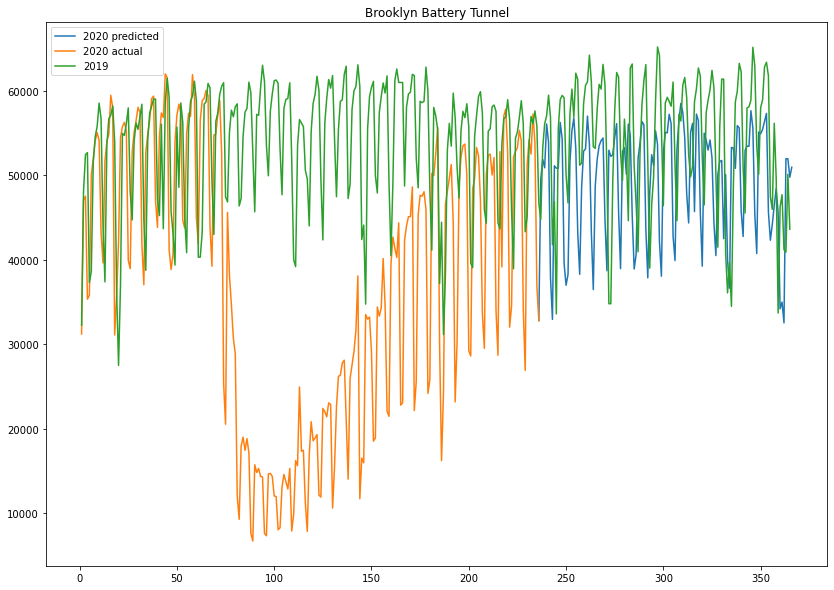

In [96]:

plt.figure(figsize=(14,10))
plt.plot(_plaza8['2020-08-23':].index.dayofyear,
         _plaza8['2020-08-23':]['value'], label = '2020 predicted')

plt.plot(_plaza8['2020-01-01':'2020-08-23'].index.dayofyear, 
         _plaza8['2020-01-01':'2020-08-23']['value'], label = '2020 actual')
plt.plot(_plaza8['2019'].index.dayofyear, 
         _plaza8['2019']['value'], label = '2019')
plt.title('Brooklyn Battery Tunnel')
plt.legend()

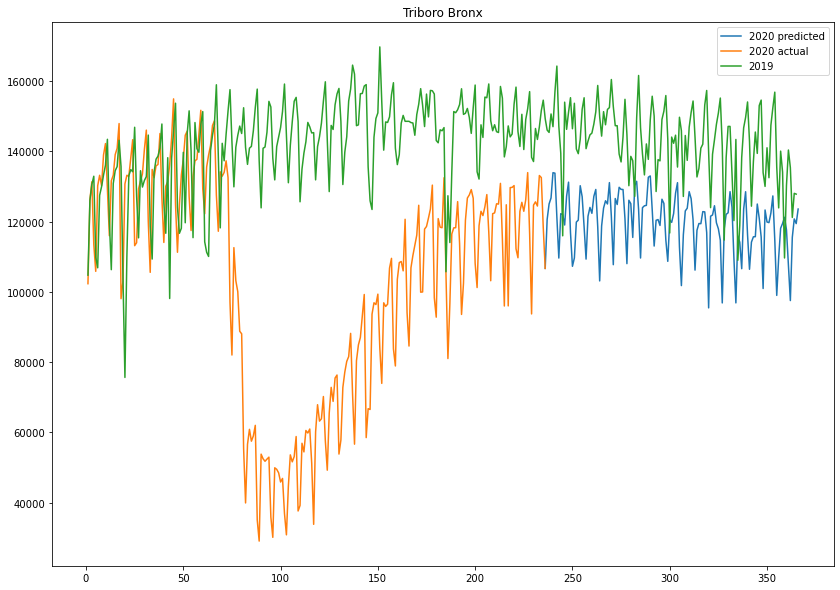

In [106]:

_plaza8 = train_roll.loc[train_roll['plaza_id'].eq(1)]
_plaza8.set_index('datetime', inplace=True)

plt.figure(figsize=(14,10))
plt.plot(_plaza8['2020-08-23':].index.dayofyear,
         _plaza8['2020-08-23':]['value'], label = '2020 predicted')

plt.plot(_plaza8['2020-01-01':'2020-08-23'].index.dayofyear, 
         _plaza8['2020-01-01':'2020-08-23']['value'], label = '2020 actual')
plt.plot(_plaza8['2019'].index.dayofyear, 
         _plaza8['2019']['value'], label = '2019')
plt.title('Triboro Bronx')
plt.legend()

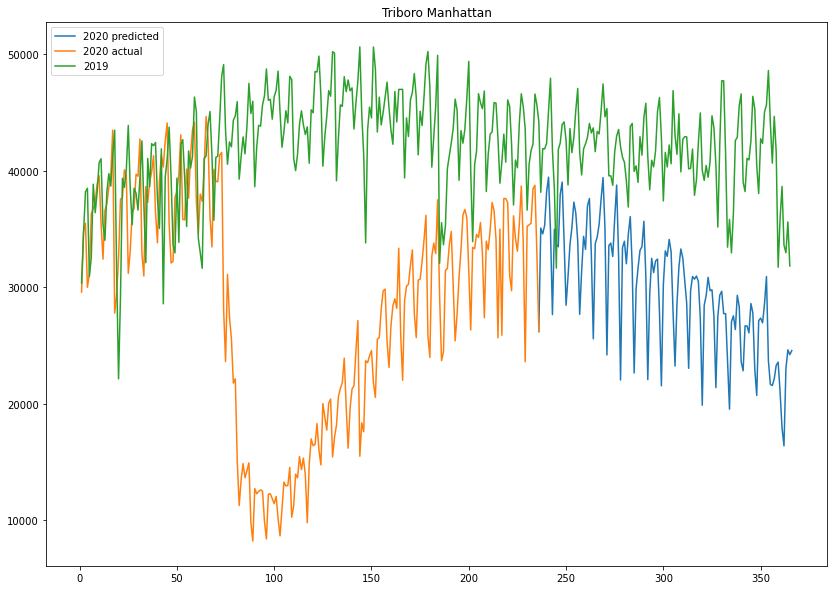

In [107]:

_plaza8 = train_roll.loc[train_roll['plaza_id'].eq(2)]
_plaza8.set_index('datetime', inplace=True)

plt.figure(figsize=(14,10))
plt.plot(_plaza8['2020-08-23':].index.dayofyear,
         _plaza8['2020-08-23':]['value'], label = '2020 predicted')

plt.plot(_plaza8['2020-01-01':'2020-08-23'].index.dayofyear, 
         _plaza8['2020-01-01':'2020-08-23']['value'], label = '2020 actual')
plt.plot(_plaza8['2019'].index.dayofyear, 
         _plaza8['2019']['value'], label = '2019')
plt.title('Triboro Manhattan')
plt.legend()

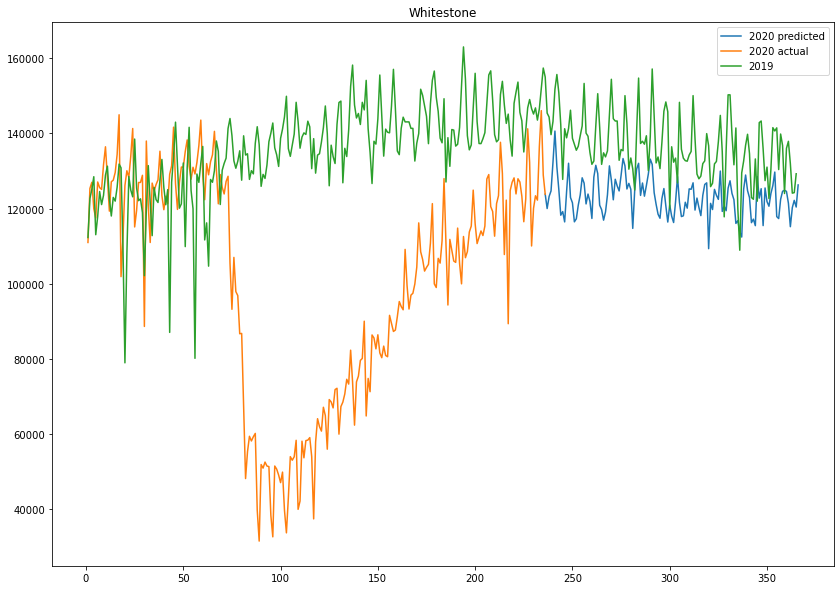

In [108]:

_plaza8 = train_roll.loc[train_roll['plaza_id'].eq(3)]
_plaza8.set_index('datetime', inplace=True)

plt.figure(figsize=(14,10))
plt.plot(_plaza8['2020-08-23':].index.dayofyear,
         _plaza8['2020-08-23':]['value'], label = '2020 predicted')

plt.plot(_plaza8['2020-01-01':'2020-08-23'].index.dayofyear, 
         _plaza8['2020-01-01':'2020-08-23']['value'], label = '2020 actual')
plt.plot(_plaza8['2019'].index.dayofyear, 
         _plaza8['2019']['value'], label = '2019')
plt.title('Whitestone')
plt.legend()

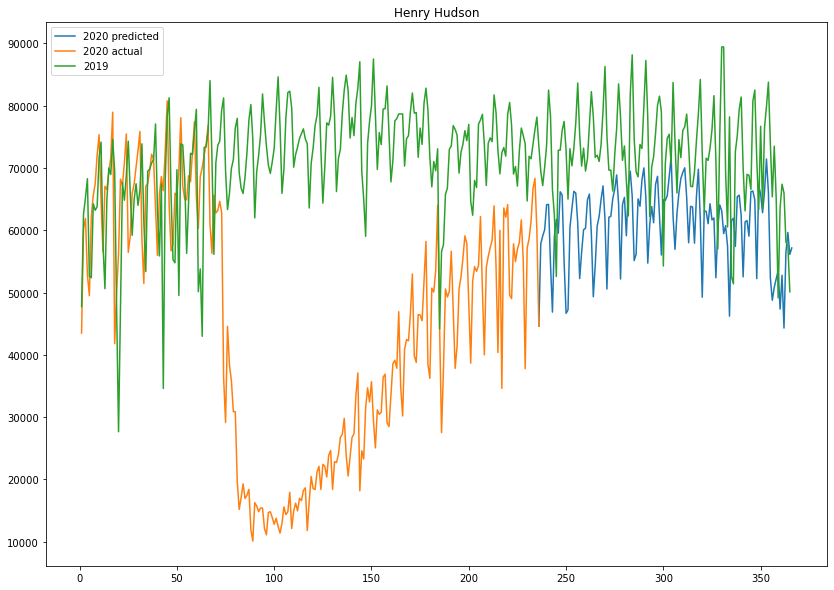

In [109]:

_plaza8 = train_roll.loc[train_roll['plaza_id'].eq(4)]
_plaza8.set_index('datetime', inplace=True)

plt.figure(figsize=(14,10))
plt.plot(_plaza8['2020-08-23':].index.dayofyear,
         _plaza8['2020-08-23':]['value'], label = '2020 predicted')

plt.plot(_plaza8['2020-01-01':'2020-08-23'].index.dayofyear, 
         _plaza8['2020-01-01':'2020-08-23']['value'], label = '2020 actual')
plt.plot(_plaza8['2019'].index.dayofyear, 
         _plaza8['2019']['value'], label = '2019')
plt.title('Henry Hudson')
plt.legend()

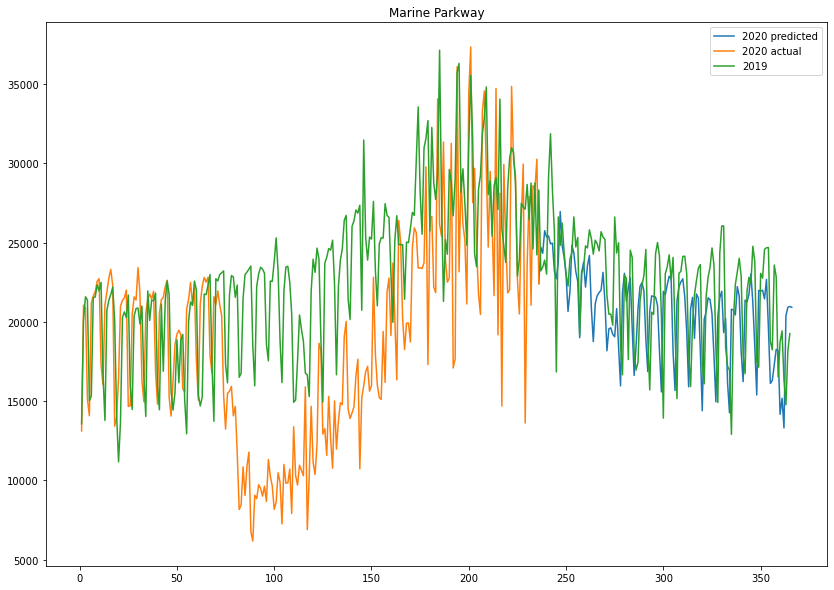

In [110]:

_plaza8 = train_roll.loc[train_roll['plaza_id'].eq(5)]
_plaza8.set_index('datetime', inplace=True)

plt.figure(figsize=(14,10))
plt.plot(_plaza8['2020-08-23':].index.dayofyear,
         _plaza8['2020-08-23':]['value'], label = '2020 predicted')

plt.plot(_plaza8['2020-01-01':'2020-08-23'].index.dayofyear, 
         _plaza8['2020-01-01':'2020-08-23']['value'], label = '2020 actual')
plt.plot(_plaza8['2019'].index.dayofyear, 
         _plaza8['2019']['value'], label = '2019')
plt.title('Marine Parkway')
plt.legend()

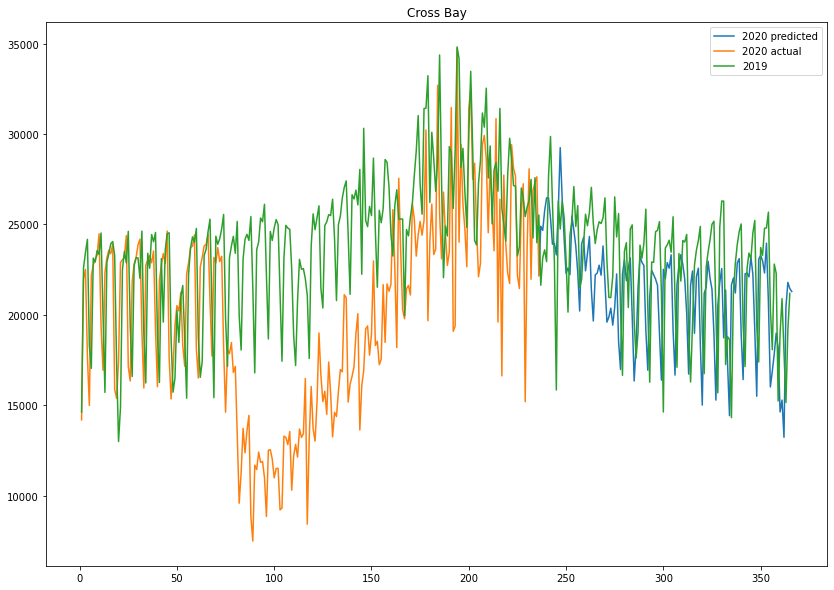

In [111]:

_plaza8 = train_roll.loc[train_roll['plaza_id'].eq(6)]
_plaza8.set_index('datetime', inplace=True)

plt.figure(figsize=(14,10))
plt.plot(_plaza8['2020-08-23':].index.dayofyear,
         _plaza8['2020-08-23':]['value'], label = '2020 predicted')

plt.plot(_plaza8['2020-01-01':'2020-08-23'].index.dayofyear, 
         _plaza8['2020-01-01':'2020-08-23']['value'], label = '2020 actual')
plt.plot(_plaza8['2019'].index.dayofyear, 
         _plaza8['2019']['value'], label = '2019')
plt.title('Cross Bay')
plt.legend()

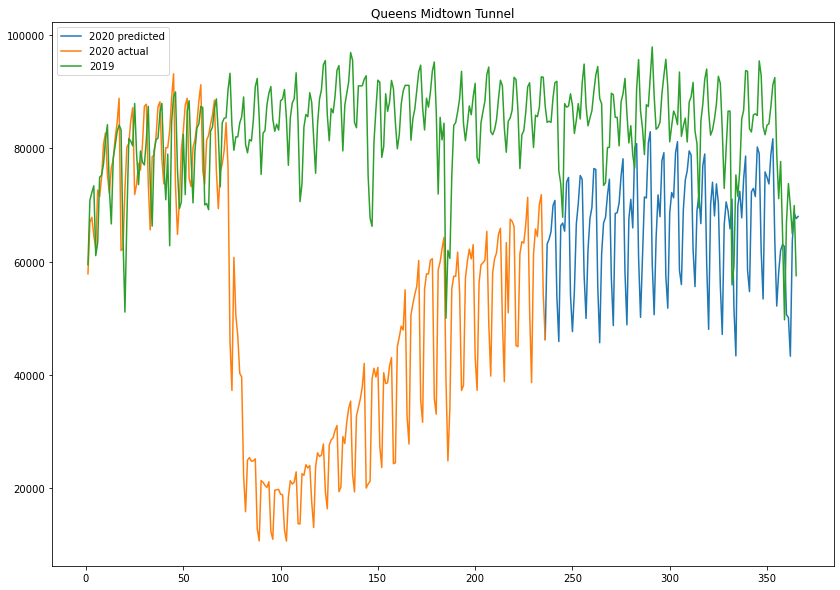

In [112]:

_plaza8 = train_roll.loc[train_roll['plaza_id'].eq(7)]
_plaza8.set_index('datetime', inplace=True)

plt.figure(figsize=(14,10))
plt.plot(_plaza8['2020-08-23':].index.dayofyear,
         _plaza8['2020-08-23':]['value'], label = '2020 predicted')

plt.plot(_plaza8['2020-01-01':'2020-08-23'].index.dayofyear, 
         _plaza8['2020-01-01':'2020-08-23']['value'], label = '2020 actual')
plt.plot(_plaza8['2019'].index.dayofyear, 
         _plaza8['2019']['value'], label = '2019')
plt.title('Queens Midtown Tunnel')
plt.legend()

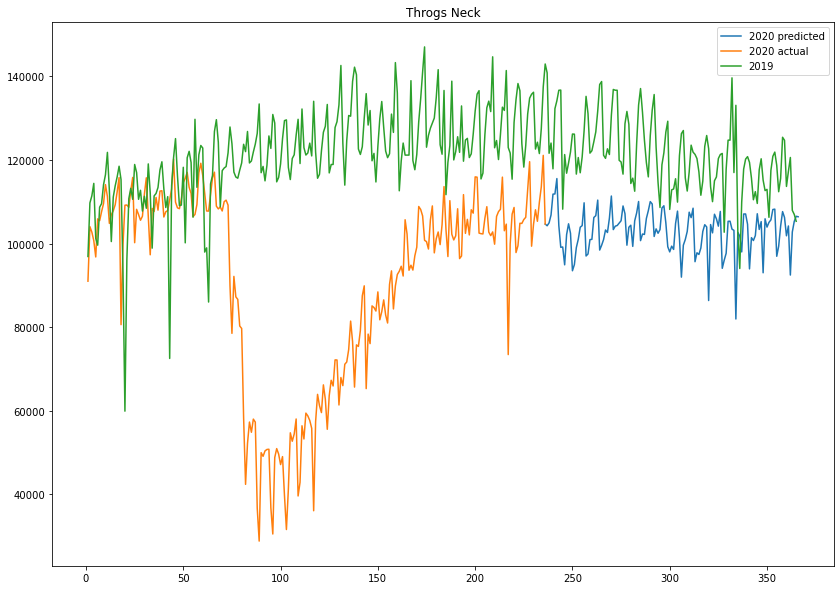

In [113]:

_plaza8 = train_roll.loc[train_roll['plaza_id'].eq(9)]
_plaza8.set_index('datetime', inplace=True)

plt.figure(figsize=(14,10))
plt.plot(_plaza8['2020-08-23':].index.dayofyear,
         _plaza8['2020-08-23':]['value'], label = '2020 predicted')

plt.plot(_plaza8['2020-01-01':'2020-08-23'].index.dayofyear, 
         _plaza8['2020-01-01':'2020-08-23']['value'], label = '2020 actual')
plt.plot(_plaza8['2019'].index.dayofyear, 
         _plaza8['2019']['value'], label = '2019')
plt.title('Throgs Neck')
plt.legend()

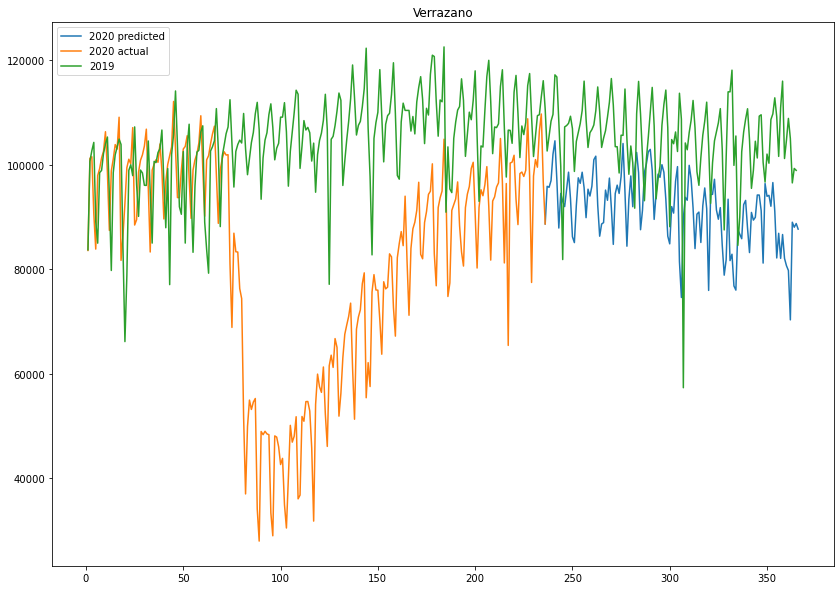

In [114]:

_plaza8 = train_roll.loc[train_roll['plaza_id'].eq(10)]
_plaza8.set_index('datetime', inplace=True)

plt.figure(figsize=(14,10))
plt.plot(_plaza8['2020-08-23':].index.dayofyear,
         _plaza8['2020-08-23':]['value'], label = '2020 predicted')

plt.plot(_plaza8['2020-01-01':'2020-08-23'].index.dayofyear, 
         _plaza8['2020-01-01':'2020-08-23']['value'], label = '2020 actual')
plt.plot(_plaza8['2019'].index.dayofyear, 
         _plaza8['2019']['value'], label = '2019')
plt.title('Verrazano')
plt.legend()

In [341]:
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(8)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']

In [342]:
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_8['value']))

4043.6559914229624

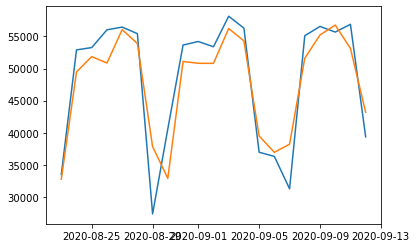

In [343]:
plt.plot(_actual_8['datetime'], _actual_8['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [344]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(3)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(3)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

6992.175600879131

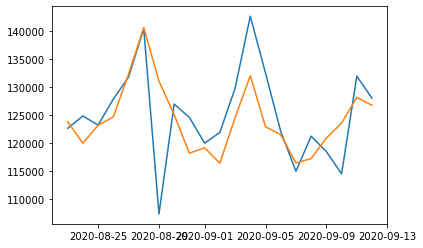

In [345]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [346]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(4)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(4)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4514.007432987268

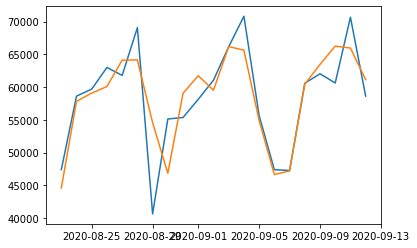

In [347]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [348]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(7)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(7)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4773.048466598711

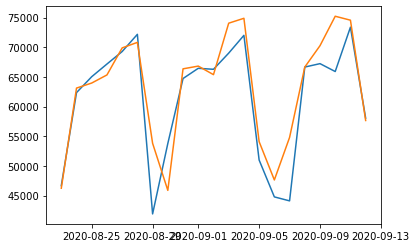

In [349]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [350]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(1)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(1)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

7218.185438239145

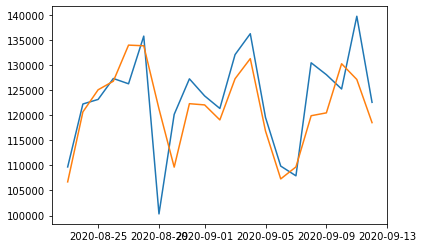

In [351]:
plt.plot(_actual_3['datetime'], _actual_3['value'])464
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [352]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(2)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(2)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

2738.383472305067

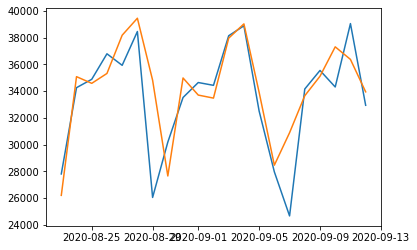

In [353]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [354]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(5)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(5)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4644.5925744054875

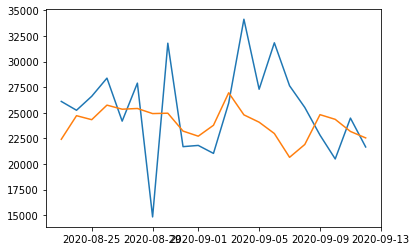

In [355]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [356]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(6)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(6)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

3114.912994526145

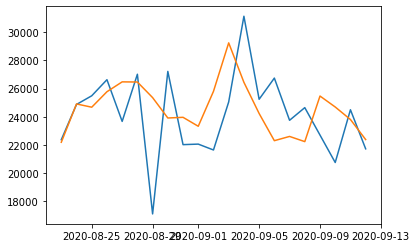

In [357]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [358]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(8)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(8)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4043.6559914229624

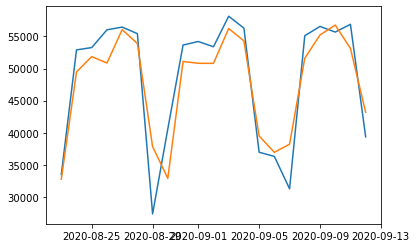

In [359]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [360]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(9)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(9)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

11189.909481761366

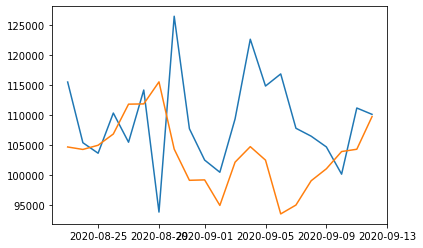

In [361]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [362]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(10)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(10)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

6050.5063718844385

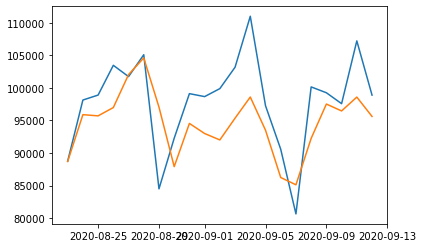

In [363]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])